In [37]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common

In [38]:
# root_dir = Path("../data_out/langmuir/finn_different_seeds")
# root_dir = Path("../data_out/langmuir/finn_different_loss_patterns")
root_dir = Path("../data_out/langmuir/finn_c_plus_better_noise")

In [39]:
records = []

for loss_path in root_dir.rglob("loss.txt"):
    finn_dir = loss_path.parent
    isotherm = "langmuir" if "langmuir" in str(finn_dir) else "freundlich"
    
    try:
        c_train = np.load(finn_dir / "c_train.npy")
        c_train_pred = np.load(finn_dir / "c_train_predictions.npy")
        c_full = np.load(finn_dir / "c_full.npy")
        c_full_pred = np.load(finn_dir / "c_full_predictions.npy")
        mse_c_train = np.square(c_train - c_train_pred).mean()
        mse_c_full = np.square(c_full - c_full_pred).mean()
    except FileNotFoundError:
        mse_c_train = np.nan
        mse_c_full = np.nan

    records.append({
        "finn_dir": finn_dir,
        "isotherm": isotherm,
        "finn_dir_label": finn_dir.name.split("_")[0],
        "epochs": len(np.loadtxt(finn_dir / "loss.txt")),
        "MSE(c_train, c_train_pred)": mse_c_train,
        "MSE(c_full, c_full_pred)": mse_c_full,
    })

finn_dir_df = pd.DataFrame.from_records(records)
display(len(finn_dir_df))
display(finn_dir_df.dtypes)
display(finn_dir_df.head())

21

finn_dir                       object
isotherm                       object
finn_dir_label                 object
epochs                          int64
MSE(c_train, c_train_pred)    float64
MSE(c_full, c_full_pred)      float64
dtype: object

,finn_dir,isotherm,finn_dir_label,epochs,"MSE(c_train, c_train_pred)","MSE(c_full, c_full_pred)"
0,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,110444009,100,0.000684,0.010137
1,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,154821933,46,NaN,NaN
2,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,935561971,100,0.203498,117.888924
3,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,440365448,100,0.000048,0.000643
4,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,801210387,100,0.000418,0.000728


In [40]:
# def has_finn_converged(finn_dir_df_row):
#     row = finn_dir_df_row
#     has_converged = True
#     if 

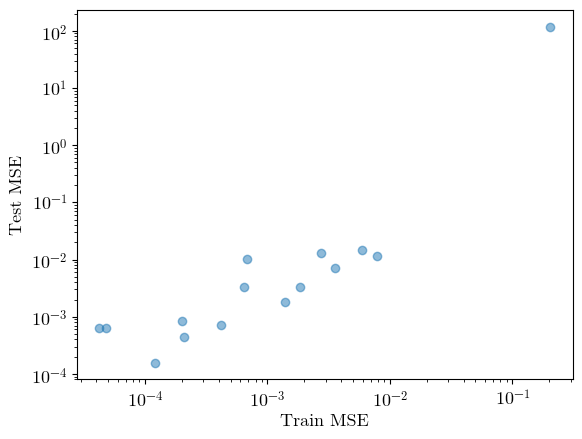

In [41]:
# tmp_mask = (finn_dir_df["MSE(c_train, c_train_pred)"] < 1e-4) & (finn_dir_df["MSE(c_train, c_train_pred)"] > 5e-6)
tmp_mask = np.ones(len(finn_dir_df), dtype=bool)
plt.scatter(finn_dir_df["MSE(c_train, c_train_pred)"][tmp_mask], finn_dir_df["MSE(c_full, c_full_pred)"][tmp_mask], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train MSE")
plt.ylabel("Test MSE")
plt.show()

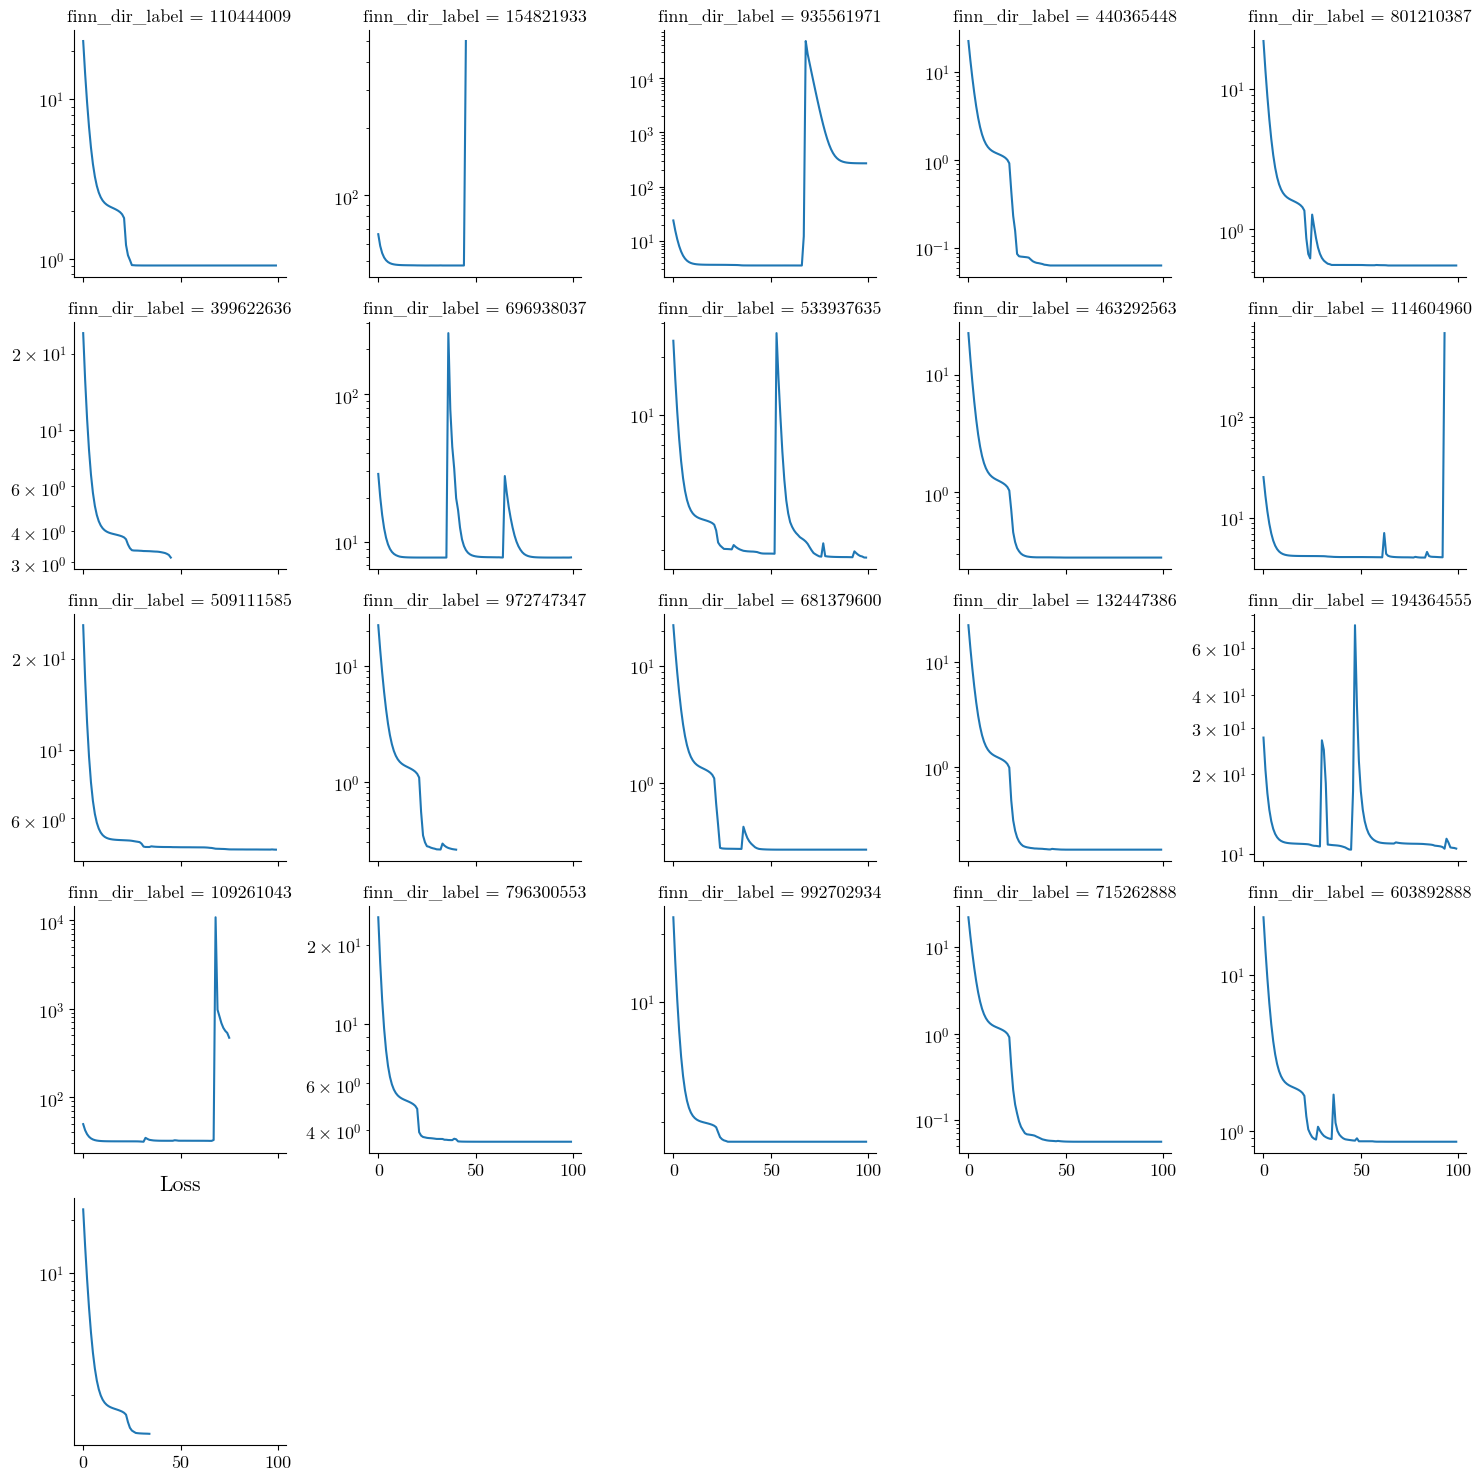

In [42]:
def load_and_plot(data, *args, **kwargs):
    y = np.loadtxt(data["finn_dir"].iloc[0] / "loss.txt")
    plt.semilogy(y, *args, **kwargs)

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    sharey=False,
)

g.map_dataframe(load_and_plot)
plt.title("Loss")
plt.show()

In [43]:
def load_analytic_retardation(finn_dir_df_row):
    return np.load(
        finn_dir_df_row["finn_dir"] / f"retardation_{finn_dir_df_row['isotherm']}.npy"
    )

## Final Retardation vs Best Retardation

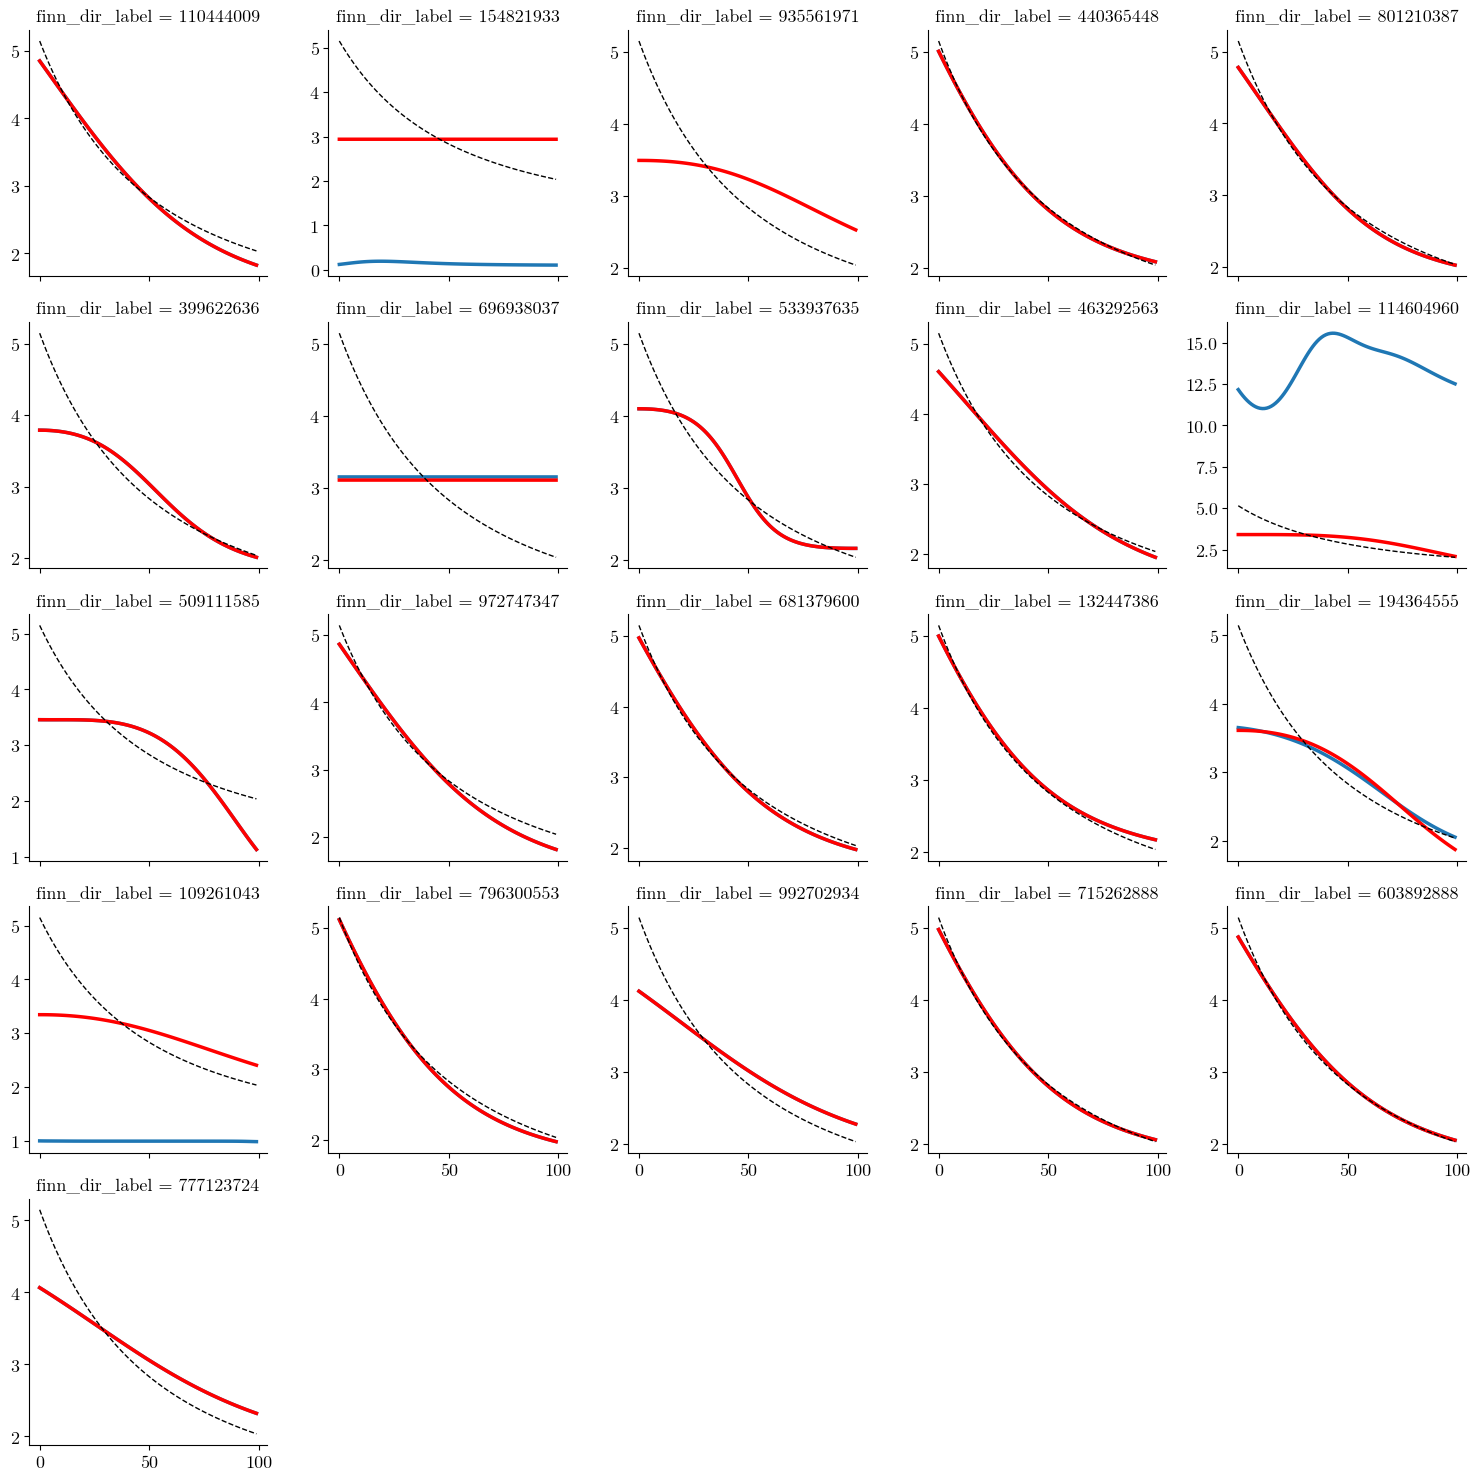

In [44]:
def final_retardation(finn_dir: Path):
    all_rets = sorted([p for p in (finn_dir / "predicted_retardations").iterdir()], key=lambda x: int(x.stem.split("_")[-1]))
    if not all_rets:
        return None
    return all_rets[-1]

def best_retardation(finn_dir: Path):
    best_epoch = np.loadtxt(finn_dir / "loss.txt").argmin() + 1
    p = finn_dir / f"predicted_retardations/retPred_{best_epoch}.npy"
    if p.exists():
        return p
    return None

def load_and_plot(data, *args, **kwargs):
    assert len(data) == 1
    y = np.load(final_retardation(data["finn_dir"].iloc[0]))
    y_best = np.load(best_retardation(data["finn_dir"].iloc[0]))
    isotherm = data["isotherm"].iloc[0]
    plt.plot(y, *args, lw=2.5, **kwargs)
    plt.plot(y_best, "r-", lw=2.5)
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    plt.plot(load_analytic_retardation(data.iloc[0]), "k--", lw=1.0, label=isotherm.capitalize())
    if isotherm == "freundlich":
        plt.ylim(min(3, y_min), max(5, y_max))
    # plt.legend()

g = sns.FacetGrid(
    data=finn_dir_df,
    col="finn_dir_label",
    col_wrap=5,
    hue="isotherm",
    sharey=False
)

g.map_dataframe(load_and_plot)
plt.show()

In [45]:
finn_dir_df

,finn_dir,isotherm,finn_dir_label,epochs,"MSE(c_train, c_train_pred)","MSE(c_full, c_full_pred)"
0,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,110444009,100,0.000684,0.010137
1,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,154821933,46,NaN,NaN
2,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,935561971,100,0.203498,117.888924
3,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,440365448,100,0.000048,0.000643
4,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,801210387,100,0.000418,0.000728
5,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,399622636,46,NaN,NaN
6,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,696938037,100,0.005946,0.014609
7,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,533937635,100,0.001382,0.001814
8,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,463292563,100,0.000209,0.000439
9,../data_out/langmuir/finn_c_plus_better_noise/...,langmuir,114604960,94,NaN,NaN


In [46]:
[str(p) for p in finn_dir_df["finn_dir"]]

['../data_out/langmuir/finn_c_plus_better_noise/110444009_cFullNoise_test3_sigma1=0.05002310872077942_sigma2=0.14217543601989746_s=2.0_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/154821933_cFullNoise_test1_None_sigma=0.08939152956008911_s=2.0_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/935561971_cFullNoise_test1_None_sigma=0.02234359681606293_s=0.5_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/440365448_cFullNoise_test3_sigma1=0.012505777180194855_sigma2=0.03545706868171692_s=0.5_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/801210387_cFullNoise_test2_51_sigma1=0.005526423826813698_sigma2=0.016651348769664766_s=1.0_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/399622636_cFullNoise_test2_None_sigma1=0.011585406959056854_sigma2=0.033110353350639346_s=0.5_finn_c_plus_better_noise',
 '../data_out/langmuir/finn_c_plus_better_noise/696938037_cFu

In [47]:
print(len(finn_dir_df))
filtered_finn_dir_df = finn_dir_df.copy()
# filtered_finn_dir_df = finn_dir_df[[("sigma=0.004" in str(p)) or ("sigma=0.002" in str(p)) for p in finn_dir_df["finn_dir"]]]
# filtered_finn_dir_df = finn_dir_df[[("sigma=0.016" in str(p)) or ("sigma=0.032" in str(p)) for p in finn_dir_df["finn_dir"]]]
# filtered_finn_dir_df = filtered_finn_dir_df[filtered_finn_dir_df["MSE(c_full, c_full_pred)"] < 1e-3]
print(len(filtered_finn_dir_df))

21
21


In [52]:
finn_dir_df["MSE(c_train, c_train_pred)"]

0     0.000684
1          NaN
2     0.203498
3     0.000048
4     0.000418
5          NaN
6     0.005946
7     0.001382
8     0.000209
9          NaN
10    0.003564
11         NaN
12    0.000201
13    0.000121
14    0.007913
15         NaN
16    0.002720
17    0.001850
18    0.000042
19    0.000639
20         NaN
Name: MSE(c_train, c_train_pred), dtype: float64

In [68]:
filtered_finn_dir_df = finn_dir_df[finn_dir_df["MSE(c_train, c_train_pred)"] < 0.0012]

In [69]:
import plotting

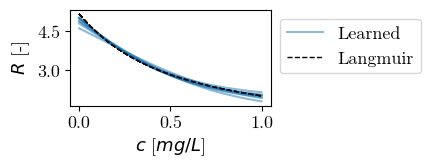

In [70]:
fig, ax = plt.subplots(figsize=(1.5*plotting.FIGURE_WIDTH, plotting.FIGURE_HEIGHT))

for i, row in filtered_finn_dir_df.iterrows():
    # ret = np.load(final_retardation(row["finn_dir"]))
    ret = np.load(best_retardation(row["finn_dir"]))
    u = np.linspace(0, 1, len(ret))
    if np.any(ret > 10):
        continue
    if np.any(ret < 1):
        continue
    isotherm = row["isotherm"]
    ax.plot(u, ret, color="tab:blue", alpha=0.5, label="Learned" if i == 0 else "")
    y_min, y_max = plt.ylim()  # get limits before plotting the analytical retardation
    
    ax.plot(u, load_analytic_retardation(row), "k--", lw=1.0, label=isotherm.capitalize() if i == 0 else "")
    if isotherm == "freundlich":
        ax.set_ylim(min(3, y_min), max(5, y_max))

ax.legend(loc="upper left", bbox_to_anchor=(1,1))

plotting.set_retardation_axes_stuff(ax, set_xlabel=True, set_ylabel=True)
plt.tight_layout()
# plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_seed")
# plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_losspattern")
plotting.savefig(fig, "../paper/figs/finn_synthetic_SPAN_noise")
plt.show()